## 2-1. 프로젝트: 새로운 데이터셋으로 나만의 이미지 분류기 만들어보기

## step1. 데이터셋 내려받기

이번에는 tensorflow_datasets 에 포함된 tf_flowers 데이터를 사용해 보겠습니다.

tf_flowers 데이터에 대한 정보는 다음에서 확인해볼 수 있습니다.

(https://www.tensorflow.org/datasets/catalog/tf_flowers)

tfds.load를 활용하여 데이터셋을 다운받으세요.

In [158]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [159]:
import tensorflow_datasets as tfds

tfds.__version__

'4.9.2'

In [160]:
# tfds.load를 이용해서 데이터셋을 불러옵니다.
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir='~/PycharmProjects/aiffel5_quest/exploration/aiffel/flowers/',
    download=True,
    with_info=True,
    as_supervised=True,
)

In [161]:
print(raw_train)
print(raw_validation)
print(raw_test)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


### Step 2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기

이미지를 모두 같은 크기로 formatting 한 후, train_batches, validation_batches, test_batches를 준비합니다.

In [162]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

2023-09-11 11:21:34.367020: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


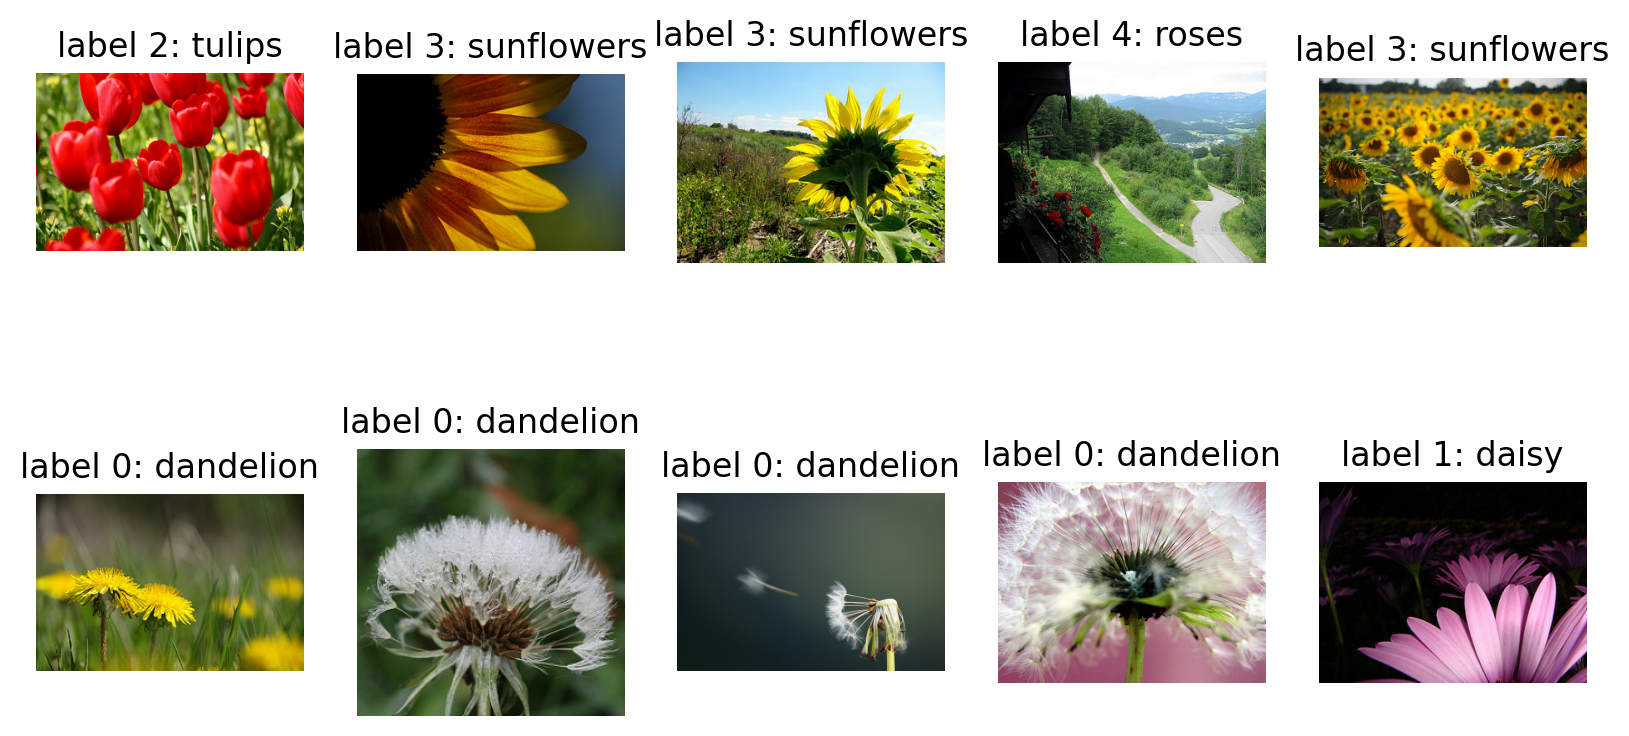

In [163]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):  # 10개의 데이터를 가져 옵니다.
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [164]:
IMG_SIZE = 160 # 리사이징할 이미지의 크기

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [165]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train)
print(validation)
print(test)

<_MapDataset element_spec=(TensorSpec(shape=(160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


2023-09-11 11:21:35.194036: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


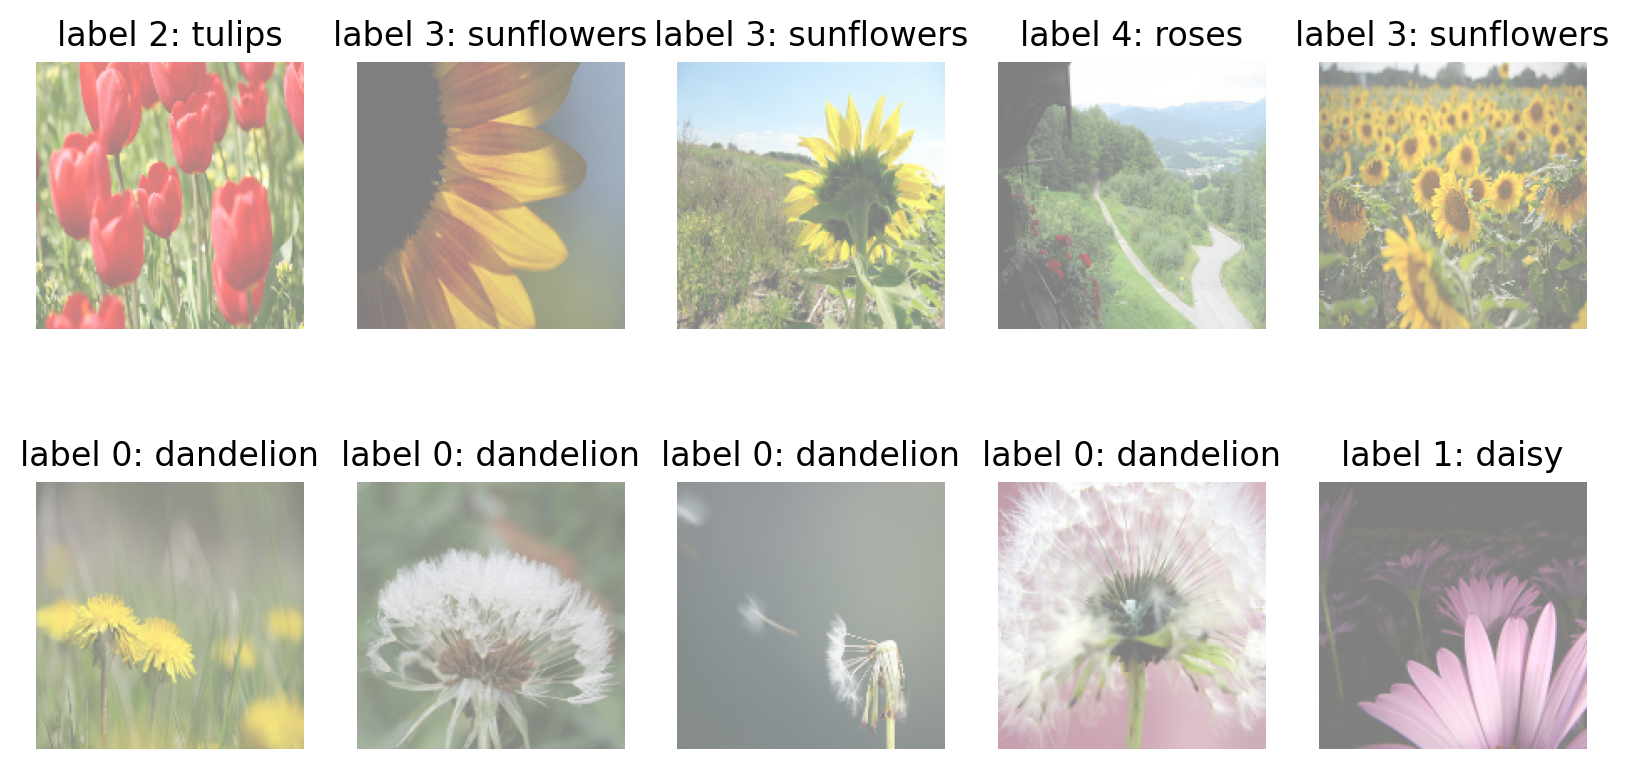

In [166]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

### Step 3. 모델 설계하기

모델은 어떤 방식으로 설계하고 싶은가요? 나만의 모델을 만들 것인가요, 아니면 base_model을 활용할 것인가요?

원하는 방식으로 모델을 만들어 보세요!

cats_vs_dogs 의 경우와 달리, tf_flowers 데이터셋에서는 class의 갯수가 5가지입니다. 모델 설계시 어느 부분이 달라질지에 유의해 주세요.

In [254]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNetV2
model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer_1 = tf.keras.layers.Dense(512, activation='relu')
batch_norm_layer_1 = tf.keras.layers.BatchNormalization()
dropout_layer_1 = tf.keras.layers.Dropout(0.5)
dense_layer_2 = tf.keras.layers.Dense(256, activation='relu')
batch_norm_layer_2 = tf.keras.layers.BatchNormalization()
dropout_layer_2 = tf.keras.layers.Dropout(0.5)
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

# Build the sequential model
base_model = tf.keras.Sequential([
    model,
    global_average_layer,
    dense_layer_1,
    batch_norm_layer_1,
    dropout_layer_1,
    dense_layer_2,
    batch_norm_layer_2,
    dropout_layer_2,
    prediction_layer
])

base_model.summary()



9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
 7 (GlobalAveragePooling2D)                                      
                                                                 
 dense_61 (Dense)            (None, 512)               655872    
                                                                 
 batch_normalization_10 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dropout_12 (Dropout)        (None, 512)               0

### Step 4. 모델 학습시키기

모델을 학습시켜봅니다. 단, 여기에서는 여러 가지 옵션을 바꿔볼 수 있습니다.

예를 들어, 모델 학습을 10 epoch보다 더 많이 시켜보거나, learning_rate 값을 바꿔볼 수 있습니다.

또는, optimizer의 종류도 바꿔볼 수 있습니다. 바꿔보고 싶다면, 여기를 참고하세요.

어쩌면 VGG16이 아닌 다른 모델을 base model로 활용할 수도 있을 것입니다. 그리고 파인튜닝을 fc layer의 구성에 변화를 줄 수 있을지도 모릅니다.

이전 스텝에서는 시도하지 않았던 Regularization 기법이 적용된다면 어떨까요? Dropout이나 Batch Normalization을 적용하는 것은 그리 어려운 일이 아닙니다.

In [255]:
learning_rate = 0.001
base_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

print("완료")

완료


In [256]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [257]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [258]:
for image_batch, label_batch in train_batches.take(1):
    break

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

In [259]:
validation_steps = 10
loss0, accuracy0 = base_model.evaluate(validation_batches, steps=validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

10/10 [==============================] - 3s 166ms/step - loss: 1.9445 - accuracy: 0.1844
initial loss: 1.94
initial accuracy: 0.18


In [260]:
EPOCHS = 15
history = base_model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/15
92/92 [==============================] - 20s 188ms/step - loss: 0.8378 - accuracy: 0.7289 - val_loss: 0.4770 - val_accuracy: 0.8474
Epoch 2/15
92/92 [==============================] - 18s 190ms/step - loss: 0.4852 - accuracy: 0.8450 - val_loss: 0.3946 - val_accuracy: 0.8965
Epoch 3/15
92/92 [==============================] - 18s 191ms/step - loss: 0.3888 - accuracy: 0.8624 - val_loss: 0.3735 - val_accuracy: 0.8801
Epoch 4/15
92/92 [==============================] - 18s 190ms/step - loss: 0.3275 - accuracy: 0.8879 - val_loss: 0.3943 - val_accuracy: 0.8937
Epoch 5/15
92/92 [==============================] - 18s 188ms/step - loss: 0.2604 - accuracy: 0.9114 - val_loss: 0.4594 - val_accuracy: 0.8774
Epoch 6/15
92/92 [==============================] - 17s 186ms/step - loss: 0.2181 - accuracy: 0.9278 - val_loss: 0.3829 - val_accuracy: 0.8883
Epoch 7/15
92/92 [==============================] - 18s 189ms/step - loss: 0.1967 - accuracy: 0.9281 - val_loss: 0.4127 - val_accuracy: 0.9019

### Step 5. 모델 성능 평가하기

모델 학습이 완료되었다면, 모델의 성능을 평가할 차례입니다.

모델이 학습된 과정을 그래프로도 그려보고, validation_batches나 test_batches에 있는 데이터에 대한 예측 결과도 확인해 보세요!

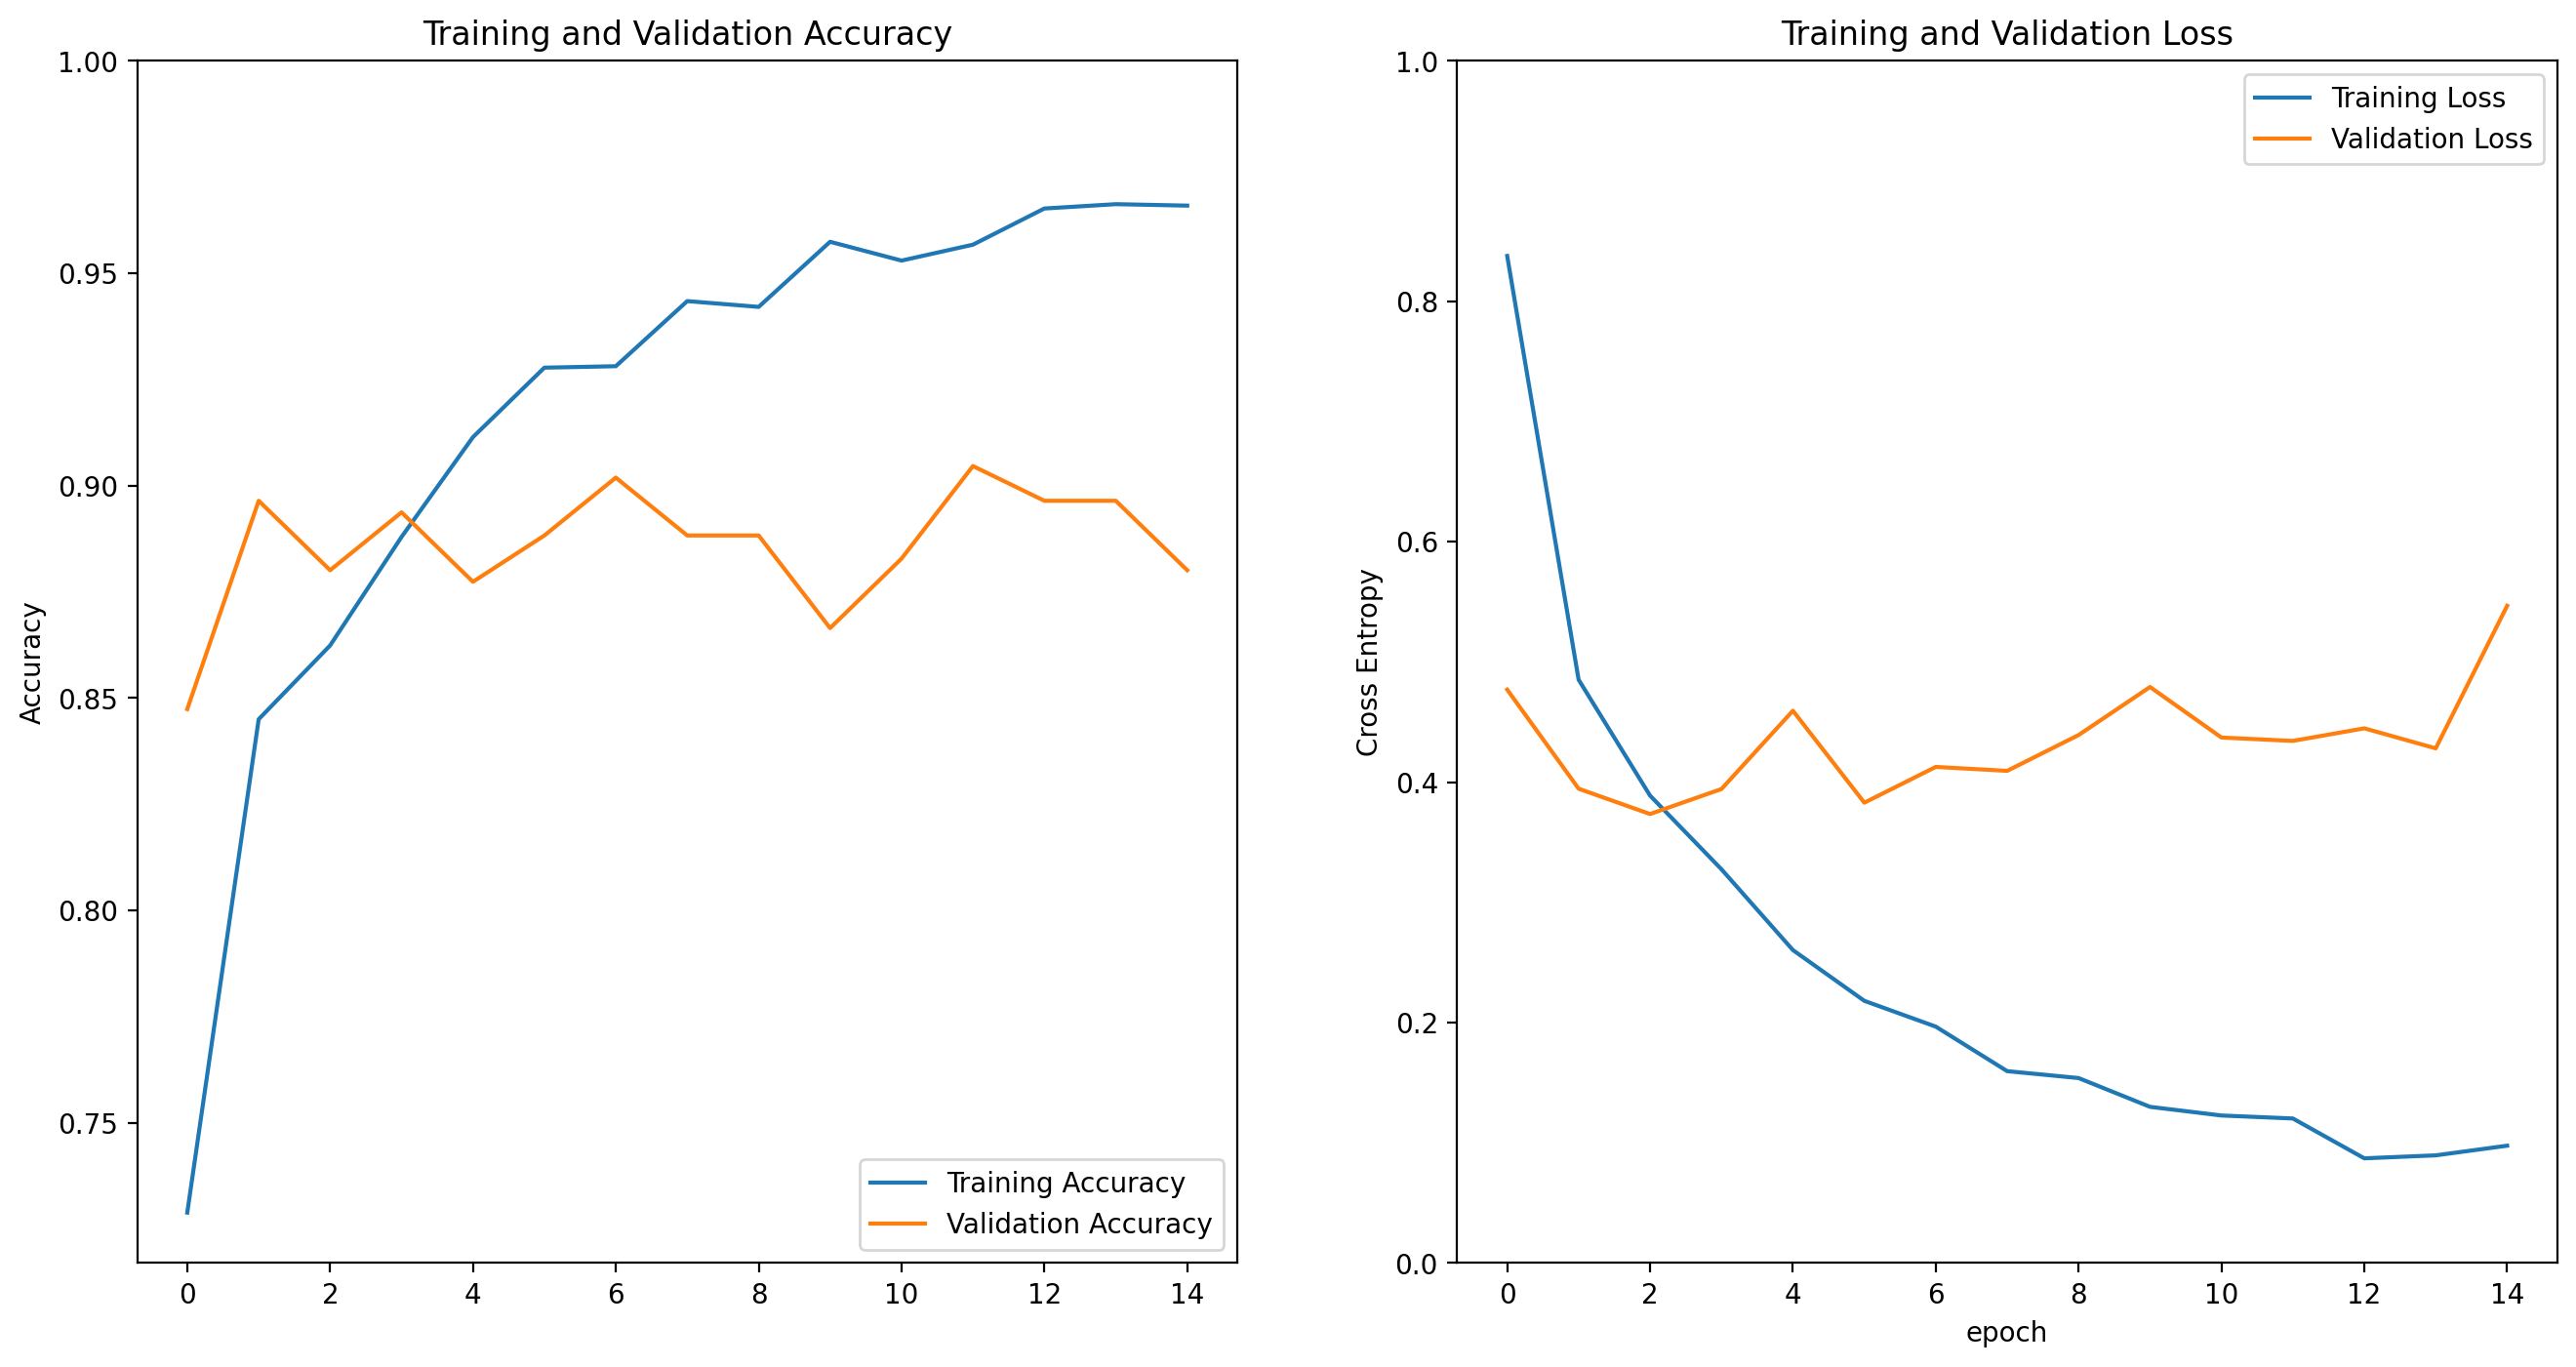

In [261]:
# 그래프로 학습과정을 보자

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [262]:
import numpy as np
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = base_model.predict(image_batch)
    pass

predictions = np.argmax(predictions, axis=1)
predictions

2023-09-11 13:11:30.557169: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


1/1 [==============================] - 1s 829ms/step


array([4, 0, 0, 2, 0, 0, 2, 3, 3, 0, 0, 0, 3, 4, 0, 3, 2, 0, 2, 4, 2, 0,
       2, 0, 1, 3, 1, 4, 4, 3, 0, 4])

In [263]:
#정확도 측정
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100) # 약 95% 내외

96.875


In [264]:
!pip install keras

### Step 6. 모델 활용하기

모델이 꽤나 똑똑해졌다면, 이제 활용해볼 수 있습니다.

원하는 이미지를 자유롭게 모델에 입력해 보고, 어떤 예측 결과를 내는지 확인해 보세요!

In [269]:

from tensorflow.keras.preprocessing.image import load_img, img_to_array

import os

In [270]:
def show_and_predict_image(dirpath, filename, img_size=160):
    filepath = os.path.join(dirpath, filename)
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    predictions = (base_model.predict(image)[0])
    prediction_idx = np.argmax((base_model.predict(image)[0]))
    
    flower_lists = metadata.features['label'].names
   
    print(f"This image seems {flower_lists[prediction_idx]} with {np.max(predictions) * 100}%.")


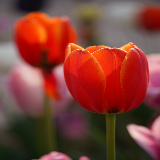

In [271]:
IMG_SIZE = 160
img_dir_path = os.getenv("HOME") + "/PycharmProjects/aiffel5_quest/exploration/aiffel/flowers/images"
face_image_path = os.path.join(img_dir_path, 'my_flowers.jpeg')

face_image = load_img(face_image_path, target_size=(IMG_SIZE, IMG_SIZE))
face_image

1/1 [==============================] - 0s 21ms/step
This image seems tulips with 68.69258284568787%.


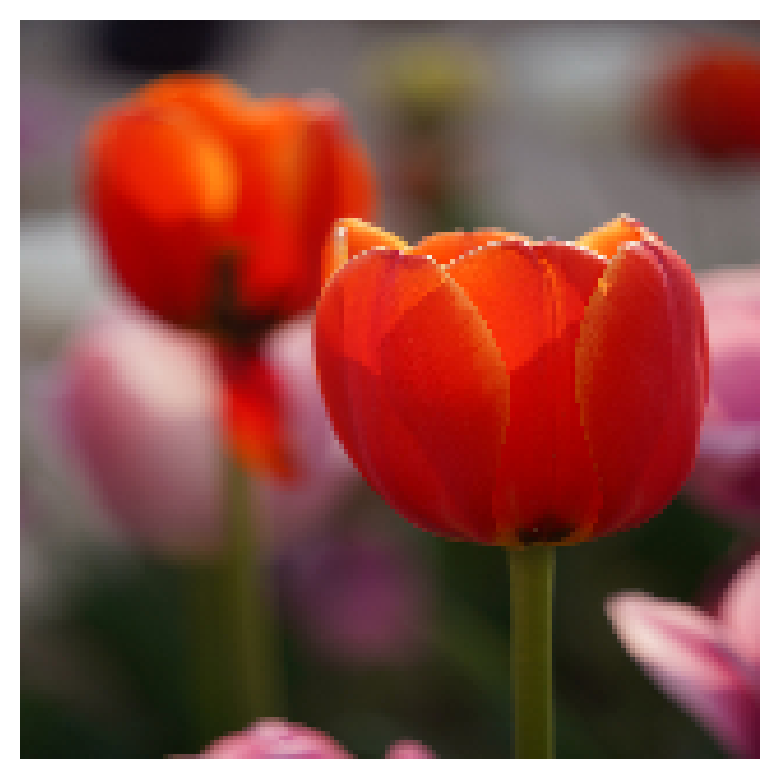

In [272]:
filename = "my_flowers.jpeg"
show_and_predict_image(img_dir_path, filename)